This notebook uses the Parametric Causal Modelling approach to Intervene on treatment variables & attacking setup variable together

In [ ]:
import numpy as np
import pandas as pd

import networkx as nx

from collections import Counter
from dowhy import gcm

from dowhy.utils import plot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [208]:
graph = nx.read_gexf("data/notears_point2.gexf")

In [209]:
df = pd.read_csv("data/features.csv")

In [210]:
df.head()

,defense_type,def_detail,corner_detail,corner_type,dynamic_movement,shot_attempt,closely_marked,attacking_setup,att_detail
0,0,Man-Mark,Inswinger,0,1,0,1,0,Attackers start from near post
1,0,Man-Mark,Inswinger,0,1,0,0,0,Attackers start from near post
2,0,Man-Mark,Inswinger,0,1,0,0,2,Two way movement
3,0,Man-Mark,Inswinger,0,1,0,1,1,Runs from deeper areas - to the back post
4,0,Man-Mark,Inswinger,0,1,0,1,0,Attackers start from near post


In [211]:
features = df[["defense_type", 'corner_type','dynamic_movement', 'shot_attempt','closely_marked','attacking_setup']]

In [212]:
features.head()

,defense_type,corner_type,dynamic_movement,shot_attempt,closely_marked,attacking_setup
0,0,0,1,0,1,0
1,0,0,1,0,0,0
2,0,0,1,0,0,2
3,0,0,1,0,1,1
4,0,0,1,0,1,0


In [213]:
causal_model = gcm.StructuralCausalModel(graph)

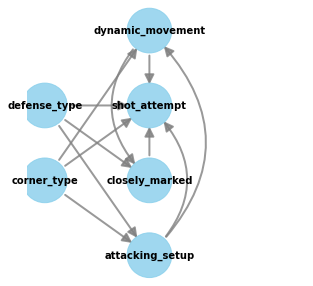

In [214]:
plot(causal_model.graph)

In [215]:
features = features.astype(str)

In [216]:
for node in graph.nodes:
    if len(list(graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.ClassifierFCM(gcm.ml.create_random_forest_classifier()))
  
    else:
        causal_model.set_causal_mechanism(node, gcm.EmpiricalDistribution())
        

In [217]:
#In case auto assignment of models is to be done for nodes

# auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, features, override_models=True, quality=gcm.auto.AssignmentQuality.BETTER)

# print(auto_assignment_summary)

#to check
# causal_model.causal_mechanism('shot_attempt')


In [219]:
gcm.fit(causal_model, features)

Fitting causal mechanism of node attacking_setup: 100%|██████████| 6/6 [00:00<00:00, 10.30it/s] 


In [221]:
features.columns

Index(['defense_type', 'corner_type', 'dynamic_movement', 'shot_attempt',
       'closely_marked', 'attacking_setup'],
      dtype='object')

In [222]:
def estimate_cate(treatment_var,outcome_var, df):
    np.random.seed(47)
    samples = gcm.interventional_samples(causal_model,
                                         {treatment_var: lambda x: np.random.choice(['0', '1'])},
                                         observed_data=df)
    eligible = samples[treatment_var] == '1'

    result = dict(treated = sorted(Counter(samples[eligible][outcome_var]).items()), non_treated = sorted(Counter(samples[~eligible][outcome_var]).items()))

    for att_type in np.sort(samples['attacking_setup'].unique()):

        group_samples = samples[samples['attacking_setup'] == att_type]
        
        eligible_in_group = group_samples[treatment_var] == '1'

        treated_in_group = sorted(Counter(group_samples[eligible_in_group][outcome_var]).items())
        
        non_treated_in_group = sorted(Counter(group_samples[~eligible_in_group][outcome_var]).items())

        result[att_type] = {}

        result[att_type]['treated'] = treated_in_group
        result[att_type]['non_treated'] = non_treated_in_group

    return result


In [223]:
treatment_var = 'corner_type'
outcome_var = 'shot_attempt'

cate_corner_type = estimate_cate(treatment_var,outcome_var,features)

cate_corner_type 

{'treated': [('0', 193), ('1', 115)],
 'non_treated': [('0', 259), ('1', 61)],
 '0': {'treated': [('0', 44), ('1', 29)],
  'non_treated': [('0', 67), ('1', 20)]},
 '1': {'treated': [('0', 49), ('1', 21)],
  'non_treated': [('0', 45), ('1', 14)]},
 '2': {'treated': [('0', 64), ('1', 32)],
  'non_treated': [('0', 105), ('1', 18)]},
 '3': {'treated': [('0', 36), ('1', 33)],
  'non_treated': [('0', 42), ('1', 9)]}}

In [224]:
treatment_var = 'defense_type'
outcome_var = 'shot_attempt'

cate_defense_type = estimate_cate(treatment_var,outcome_var,features)

cate_defense_type 

{'treated': [('0', 208), ('1', 100)],
 'non_treated': [('0', 226), ('1', 94)],
 '0': {'treated': [('0', 63), ('1', 34)],
  'non_treated': [('0', 38), ('1', 22)]},
 '1': {'treated': [('0', 38), ('1', 16)],
  'non_treated': [('0', 55), ('1', 21)]},
 '2': {'treated': [('0', 72), ('1', 32)],
  'non_treated': [('0', 90), ('1', 28)]},
 '3': {'treated': [('0', 35), ('1', 18)],
  'non_treated': [('0', 43), ('1', 23)]}}

In [225]:
def actual_cate(treatment_var,outcome_var, df):
  
    eligible = df[treatment_var] == '1'

    result = dict(treated = sorted(Counter(df[eligible][outcome_var]).items()), non_treated = sorted(Counter(df[~eligible][outcome_var]).items()))

    for att_type in np.sort(df['attacking_setup'].unique()):

        group_samples = df[df['attacking_setup'] == att_type]
        
        eligible_in_group = group_samples[treatment_var] == '1'

        treated_in_group = sorted(Counter(group_samples[eligible_in_group][outcome_var]).items())
        
        non_treated_in_group = sorted(Counter(group_samples[~eligible_in_group][outcome_var]).items())

        result[att_type] = {}

        result[att_type]['treated'] = treated_in_group
        result[att_type]['non_treated'] = non_treated_in_group

    return result


In [226]:
treatment_var = 'corner_type'
outcome_var = 'shot_attempt'

real_cate_corner_type = actual_cate(treatment_var,outcome_var,features)

real_cate_corner_type 

{'treated': [('0', 214), ('1', 117)],
 'non_treated': [('0', 244), ('1', 53)],
 '0': {'treated': [('0', 52), ('1', 31)],
  'non_treated': [('0', 71), ('1', 17)]},
 '1': {'treated': [('0', 39), ('1', 24)],
  'non_treated': [('0', 49), ('1', 11)]},
 '2': {'treated': [('0', 82), ('1', 37)],
  'non_treated': [('0', 88), ('1', 17)]},
 '3': {'treated': [('0', 41), ('1', 25)],
  'non_treated': [('0', 36), ('1', 8)]}}

In [227]:
treatment_var = 'defense_type'
outcome_var = 'shot_attempt'

real_cate_defense_type = actual_cate(treatment_var,outcome_var,features)

real_cate_defense_type 

{'treated': [('0', 194), ('1', 77)],
 'non_treated': [('0', 264), ('1', 93)],
 '0': {'treated': [('0', 64), ('1', 25)],
  'non_treated': [('0', 59), ('1', 23)]},
 '1': {'treated': [('0', 31), ('1', 12)],
  'non_treated': [('0', 57), ('1', 23)]},
 '2': {'treated': [('0', 72), ('1', 29)],
  'non_treated': [('0', 98), ('1', 25)]},
 '3': {'treated': [('0', 27), ('1', 11)],
  'non_treated': [('0', 50), ('1', 22)]}}

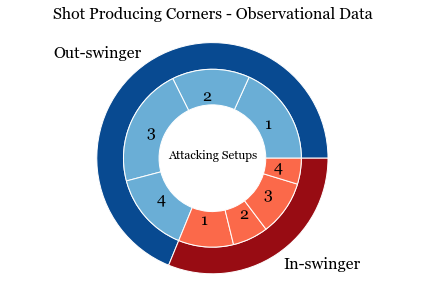

In [230]:
hfont = {'fontname':'Georgia'}


group_names=['Out-swinger','In-swinger']
group_size=[117,53]

subgroup_names=['1', '2', '3', '4','1', '2', '3', '4']
subgroup_size=[31,24,37,25,17,11,17,8]
 
a, b=[plt.cm.Blues, plt.cm.Reds]
 

fig, ax = plt.subplots()
ax.axis('equal')
fontdict = {'fontsize': 16, 'fontname': 'Georgia'}

fontdict_2 = {'fontsize': 12, 'fontname': 'Georgia'}


mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.9), b(0.9)] ,textprops=fontdict)
plt.setp( mypie, width=0.3, edgecolor='white')
 

mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.5), a(0.5),a(0.5), b(0.5), b(0.5),b(0.5),b(0.5)] ,textprops=fontdict)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
plt.title("Shot Producing Corners - Observational Data",y = 1.1, **fontdict)

plt.text(x= -0.5, y=0, s = "Attacking Setups", **fontdict_2)

plt.tight_layout()
# plt.savefig("Shot Producing Corners - Observational Data.png") 

plt.show()

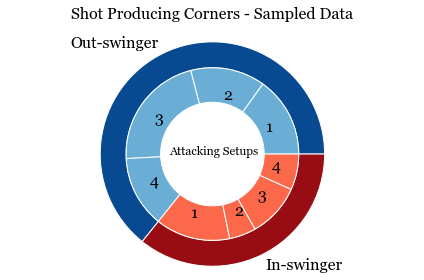

In [231]:
# Make data: I have 3 groups and 7 subgroups
group_names=[ 'Out-swinger','In-swinger']
group_size=[115,64]

{'treated': [('0', 193), ('1', 115)],
 'non_treated': [('0', 256), ('1', 64)],
 '0': {'treated': [('0', 38), ('1', 27)],
  'non_treated': [('0', 81), ('1', 25)]},
 '1': {'treated': [('0', 45), ('1', 25)],
  'non_treated': [('0', 53), ('1', 9)]},
 '2': {'treated': [('0', 70), ('1', 39)],
  'non_treated': [('0', 85), ('1', 18)]},
 '3': {'treated': [('0', 40), ('1', 24)],
  'non_treated': [('0', 37), ('1', 12)]}}

fontdict_2 = {'fontsize': 12, 'fontname': 'Georgia'}

subgroup_names=['1', '2', '3', '4','1', '2', '3', '4']
subgroup_size=[27,25,39,24,25,9,18,12]
 

a, b=[plt.cm.Blues, plt.cm.Reds]
 

fig, ax = plt.subplots()
ax.axis('equal')
fontdict = {'fontsize': 16, 'fontname': 'Georgia'}

mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.9), b(0.9)],textprops=fontdict)
plt.setp( mypie, width=0.3, edgecolor='white')
 

mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.5), a(0.5),a(0.5), b(0.5), b(0.5),b(0.5),b(0.5)] ,textprops=fontdict)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
plt.title("Shot Producing Corners - Sampled Data",y = 1.1, **fontdict)
plt.text(x= -0.5, y=0, s = "Attacking Setups", **fontdict_2)

plt.tight_layout()
# plt.savefig("Shot Producing Corners - Sampled Data.png") 

# show it
plt.show()

In [233]:
def estimate_cde(treatment_var,outcome_var, df):
    overall_cde = {}
    for att_type in np.sort(df['attacking_setup'].unique()):
        np.random.seed(50)
        non_treated_samples = gcm.interventional_samples(causal_model,
                                                {treatment_var: lambda x: '0', 'attacking_setup': lambda x: att_type},
                                                num_samples_to_draw=1000)
        
        treated_samples = gcm.interventional_samples(causal_model,
                                                {treatment_var: lambda x: '1', 'attacking_setup': lambda x: att_type},
                                                num_samples_to_draw=1000)


        result = dict(treated = sorted(Counter(treated_samples[outcome_var]).items()), non_treated = sorted(Counter(non_treated_samples[outcome_var]).items()))
        
        overall_cde[att_type] = result

    return overall_cde


In [234]:
treatment_var = 'corner_type'
outcome_var = 'shot_attempt'

cde_corner_type = estimate_cde(treatment_var,outcome_var,features)

cde_corner_type 

{'0': {'treated': [('0', 600), ('1', 400)],
  'non_treated': [('0', 791), ('1', 209)]},
 '1': {'treated': [('0', 658), ('1', 342)],
  'non_treated': [('0', 828), ('1', 172)]},
 '2': {'treated': [('0', 690), ('1', 310)],
  'non_treated': [('0', 816), ('1', 184)]},
 '3': {'treated': [('0', 578), ('1', 422)],
  'non_treated': [('0', 827), ('1', 173)]}}

In [235]:
treatment_var = 'defense_type'
outcome_var = 'shot_attempt'

cde_defense_type = estimate_cde(treatment_var,outcome_var,features)

cde_defense_type 

{'0': {'treated': [('0', 720), ('1', 280)],
  'non_treated': [('0', 669), ('1', 331)]},
 '1': {'treated': [('0', 766), ('1', 234)],
  'non_treated': [('0', 701), ('1', 299)]},
 '2': {'treated': [('0', 702), ('1', 298)],
  'non_treated': [('0', 771), ('1', 229)]},
 '3': {'treated': [('0', 715), ('1', 285)],
  'non_treated': [('0', 692), ('1', 308)]}}

C:\Users\mishr\AppData\Local\Temp/ipykernel_2044/3140557307.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("sample_corner_type.png",bbox='tight')


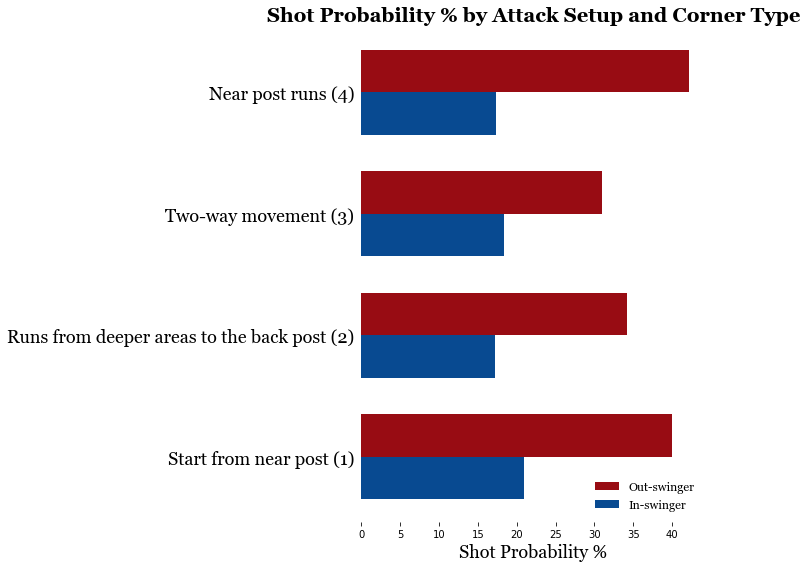

In [63]:

a, b = plt.cm.Blues, plt.cm.Reds


color_index_a, color_index_b = 0.9, 0.9

hfont = {'fontname':'Georgia', 'fontsize': 18}


color_a = mcolors.to_hex(a(color_index_a))
color_b = mcolors.to_hex(b(color_index_b))

data = {
    'Attack Setup': ["Start from near post (1)", "Runs from deeper areas to the back post (2)", "Two-way movement (3)", "Near post runs (4)"],
    'In-swinger': [20.9, 17.2,18.4,17.3],
    'Out-swinger': [40.0,34.2,31.0,42.2]
}


num_bars = len(data['Attack Setup'])


bar_width = 0.35
spacing = 0


fig, ax = plt.subplots(figsize=(10, 8))


bars_1 = ax.barh(np.arange(num_bars) + bar_width + spacing, data['Out-swinger'], bar_width, color=color_b, label='Out-swinger')


bars_0 = ax.barh(np.arange(num_bars), data['In-swinger'], bar_width, color=color_a, label='In-swinger')


ax.set_yticks(np.arange(num_bars) + bar_width / 2 + spacing)
ax.set_yticklabels(data['Attack Setup'], **hfont)
ax.set_xlabel('Shot Probability %', **hfont)

ax.set_title('Shot Probability % by Attack Setup and Corner Type', **{'fontname':'Georgia', 'fontsize': 20, 'fontweight': 'bold'})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.tick_params(axis='y', which='both', left=False)


legend = ax.legend(fontsize='large')
legend.get_frame().set_linewidth(0) 
legend.get_frame().set_facecolor('none')  
legend.get_frame().set_edgecolor('none') 
legend.get_texts()[0].set_fontname('Georgia') 
legend.get_texts()[1].set_fontname('Georgia') 

plt.tight_layout()
# plt.savefig("sample_corner_type.png",bbox='tight') 

plt.show()


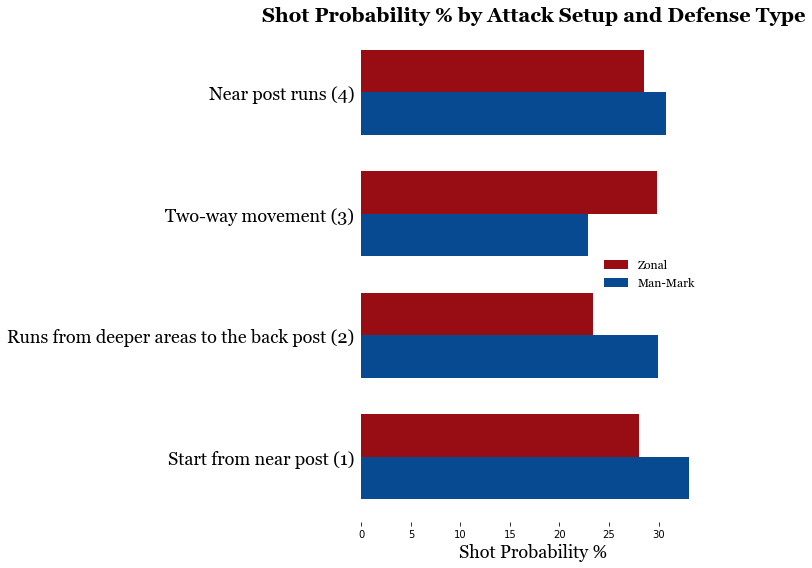

In [64]:
a, b = plt.cm.Blues, plt.cm.Reds


color_index_a, color_index_b = 0.9, 0.9

hfont = {'fontname':'Georgia', 'fontsize': 18}


color_a = mcolors.to_hex(a(color_index_a))
color_b = mcolors.to_hex(b(color_index_b))


data = {
    'Attack Setup': ["Start from near post (1)", "Runs from deeper areas to the back post (2)", "Two-way movement (3)", "Near post runs (4)"],
    'Man-Mark': [33.1,29.9,22.9,30.8],
    'Zonal': [28,23.4,29.8,28.5]
}


num_bars = len(data['Attack Setup'])


bar_width = 0.35
spacing = 0


fig, ax = plt.subplots(figsize=(10, 8))


bars_1 = ax.barh(np.arange(num_bars) + bar_width + spacing, data['Zonal'], bar_width, color=color_b, label='Zonal')



bars_0 = ax.barh(np.arange(num_bars), data['Man-Mark'], bar_width, color=color_a, label='Man-Mark')



ax.set_yticks(np.arange(num_bars) + bar_width / 2 + spacing)
ax.set_yticklabels(data['Attack Setup'], **hfont)
ax.set_xlabel('Shot Probability %', **hfont)

ax.set_title('Shot Probability % by Attack Setup and Defense Type', **{'fontname':'Georgia', 'fontsize': 20, 'fontweight': 'bold'})


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.tick_params(axis='y', which='both', left=False)


legend = ax.legend(fontsize='large')
legend.get_frame().set_linewidth(0)  
legend.get_frame().set_facecolor('none')  
legend.get_frame().set_edgecolor('none') 
legend.get_texts()[0].set_fontname('Georgia')  
legend.get_texts()[1].set_fontname('Georgia')  

plt.tight_layout()
# plt.savefig("sample_defense_type.png", bbox_inches='tight') 

plt.show()
